In [1]:
#Install the lastest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
#Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

     |████████████████████████████████| 1.6MB 5.2MB/s 
     |████████████████████████████████| 45.3MB 90kB/s 
     |████████████████████████████████| 96 kB 2.7 MB/s 
     |████████████████████████████████| 52 kB 884 kB/s 


In [2]:
import jax
import jax.numpy as jnp
from jax import grad
from jax import random
import flax.linen as nn
import numpy as np

f=lambda x:x**3+2*x**2-3*x+1

dfdx=grad(f)
d2fdx=grad(grad(f))

In [ ]:
print(dfdx(1.))
print(d2fdx(1.))

4.0
10.0


In [ ]:
hessian(f)(1.)

DeviceArray(10., dtype=float32)

In [ ]:
def f(x):
  return jnp.dot(x,x)

def hessian(f):
  return jax.jacfwd(grad(f))

In [ ]:
hessian(f)(jnp.array([1.,2.]))

DeviceArray([[2., 0.],
             [0., 2.]], dtype=float32)

In [ ]:
def norm(X):
  X=X-X.mean(0)
  return X/X.std(0)

In [ ]:
from jax import jit
norm_compiled=jit(norm)

In [ ]:
np.random.seed(1701)
X=jnp.array(np.random.rand(10000,10))
np.allclose(norm(X),norm_compiled(X),atol=1E-6)

True

In [ ]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

100 loops, best of 5: 4.44 ms per loop
1000 loops, best of 5: 408 µs per loop


In [ ]:
def get_negatives(x):
  return x[x<0]

x=jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-1.2571421 , -0.48511598, -0.9863928 , -0.26037157,
             -0.49505737], dtype=float32)

The most commonly used pytree functions are jax.tree_map and jax.tree_multimap. They work analogously to Python’s native map, but on entire pytrees.

In [ ]:
list_of_lists=[
               [1,2,3],
               [1,2],
               [1,2,3,4]
]

jax.tree_map(lambda x:x*2,list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [ ]:
another_list_of_lists=list_of_lists
jax.tree_multimap(lambda x,y:x+y,list_of_lists,another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [ ]:
def init_mlp_params(layer_widths):
  params=[]
  for n_in,n_out in zip(layer_widths[:-1],layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in,n_out))*np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,)))
    )
  return params

params=init_mlp_params([1,128,128,1])

In [ ]:
jax.tree_map(lambda x:x.shape,params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [ ]:
def forward(params,x):
  *hidden,last=params
  for layer in hidden:
    x=jax.nn.relu(x@layer['weights']+layer['biases'])
  return x@last['weights']+last['biases']

def loss_fn(params,x,y):
  return jnp.mean((forward(params,x)-y)**2)

LEARNING_RATE=0.0001

@jax.jit
def update(params,x,y):
  grads=jax.grad(loss_fn)(params,x,y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has built-in support for pytrees.
  return jax.tree_multimap(lambda p,g:p-LEARNING_RATE*g,params,grads)

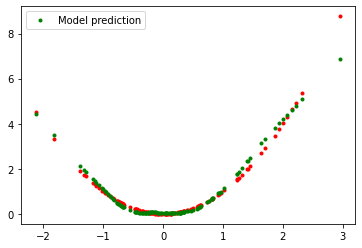

In [ ]:
import matplotlib.pyplot as plt

xs=np.random.normal(size=(128,1))
ys=xs**2

for _ in range(1000):
  params=update(params,xs,ys)

plt.plot(xs,ys,'.',c='red')
plt.plot(xs,forward(params,xs),'.',c='green',label='Model prediction')
plt.legend()
plt.show()

In [ ]:
example_trees=[[1,2],3,[4,5,6]]

print(jax.tree_leaves(example_trees))
print(jax.tree_flatten(example_trees)[0])

[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6]


In [ ]:
example_trees=[
      [1,'a',object()],
      (1,(2,3),()),
      [1,{'k1':1,'k2':(3,4)},5],
      {'a':2,'b':(2,3)},
      jnp.array([1,2,3]),         
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves=jax.tree_leaves(pytree)
  print(f'{repr(pytree):<45} has {len(leaves)} leaves:{leaves}')

[1, 'a', <object object at 0x7f838855ebc0>]   has 3 leaves:[1, 'a', <object object at 0x7f838855ebc0>]
(1, (2, 3), ())                               has 3 leaves:[1, 2, 3]
[1, {'k1': 1, 'k2': (3, 4)}, 5]               has 5 leaves:[1, 1, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves:[2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves:[DeviceArray([1, 2, 3], dtype=int32)]


In [ ]:
example_trees=[('a','b','c'),('d','e')]

print(jax.tree_map(lambda x:x+'b',example_trees))

[('ab', 'bb', 'cb'), ('db', 'eb')]


In [ ]:
from typing import  Sequence

class MLP(nn.Module):
  features:Sequence[int]

  @nn.compact
  def __call__(self,x):
    for feat in self.features[:-1]:
      x=nn.Dense(feat)(x)
      x=nn.relu(x)
    x=nn.Dense(self.features[-1])(x)
    return x     

In [ ]:
model=MLP([32,32,10])
batched_x=jnp.ones((32,10))
rng=random.PRNGKey(0)
params=model.init(rng,batched_x)
jax.tree_map(lambda x:x.shape,params)

FrozenDict({
    params: {
        Dense_0: {
            bias: (32,),
            kernel: (10, 32),
        },
        Dense_1: {
            bias: (32,),
            kernel: (32, 32),
        },
        Dense_2: {
            bias: (10,),
            kernel: (32, 10),
        },
    },
})

In [ ]:
output=model.apply(params,batched_x)
print(output.shape)

(32, 10)


In [3]:
import jax
import jax.numpy as jnp
from jax import random,grad,vmap

In [ ]:
print('jax version:',jax.__version__)
#Check the jax backend
print('jax backend:',jax.lib.xla_bridge.get_backend().platform)

jax version: 0.2.13
jax backend: cpu


In [ ]:
print(jax.devices())

[CpuDevice(id=0)]


In [ ]:
x=jnp.array([1,2,3])
y=jax.nn.one_hot(a,4)
print(y)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
x=jnp.arange(5)
w=jnp.array([2.,3.,4.])

def convolve(x,w):
  output=[]
  for i in range(1,len(x)-1):
    output.append(jnp.dot(x[i-1:i+2],w))
  return jnp.array(output)

In [ ]:
print(convolve(x,w))

[11. 20. 29.]


In [ ]:
xs=jnp.stack([x,x])
ws=jnp.stack([w,w])

def manually_batched_convolve(xs,ws):
  output=[]
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i],ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs,ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

In [ ]:
def manually_vectorize_convolve(xs,ws):
  output=[]                             
  for i in range(1,xs.shape[-1]-1):
    print(xs[:,i-1:i+2]*ws)
    output.append(jnp.sum(xs[:,i-1:i+2]*ws,axis=1)) 
  #print(output)  
  return jnp.stack(output,axis=1)

manually_vectorize_convolve(xs,ws)

[[0. 3. 8.]
 [0. 3. 8.]]
[[ 2.  6. 12.]
 [ 2.  6. 12.]]
[[ 4.  9. 16.]
 [ 4.  9. 16.]]


DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

In [ ]:
auto_batch_convolve=vmap(convolve)
auto_batch_convolve(xs,ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

## Axes
By default, vmap vectorizes over the first axis of each of its inputs. If the first argument has a batch and the second does not, ,specify `in_axes=[0,None]`, so the second argument is not vectorized over.

In [ ]:
vmap(convolve,in_axes=[0,None])(xs,w)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

In [ ]:
w=np.random.normal(size=(3,))
X=np.random.normal(size=(10,3))

def sigmoid(x):
  return 0.5*(jnp.tanh(x/2.)+1)

def predict(x):
  return sigmoid(jnp.dot(w,x))   #(3,)*(3,)->1

In [ ]:
print(sigmoid(X).shape)

(10, 3)


In [ ]:
predict(X[0])

DeviceArray(0.036, dtype=float32)

In [ ]:
def manual_batch_predict(x):
  return sigmoid(jnp.dot(x,w))  #jnp.dot(w,x.T)

manual_batch_predict(X)

DeviceArray([0.036, 0.469, 0.12 , 0.744, 0.471, 0.29 , 0.808, 0.944,
             0.235, 0.819], dtype=float32)

In [ ]:
auto_batch_predict=vmap(predict)(X)
auto_batch_predict

DeviceArray([0.036, 0.469, 0.12 , 0.744, 0.471, 0.29 , 0.808, 0.944,
             0.235, 0.819], dtype=float32)

##Partial derivatives

$$
\begin{align}
f(x,y) &= x^2 + y \\
\frac{\partial f}{\partial x} &= 2x \\
\frac{\partial f}{\partial y} &= 1 
\end{align}
$$

In [ ]:
def f(x,y):
  return x**2+y

In [ ]:
x=2.
y=3.

v,gx=jax.value_and_grad(f,argnums=0)(x,y)
print(v)
print(gx)

v,gy=jax.value_and_grad(f,argnums=1)(x,y)
print(gy)

7.0
4.0
1.0


##Gradients

Linear function: multi-input, scalar output.

$$
\begin{align}
f(x; a) &= a^T x\\
\nabla_x f(x;a) &= a
\end{align}
$$

In [ ]:
np.random.seed(0)

In [ ]:
def f(x):
  return jnp.dot(a,x)[0]

x=np.random.normal(size=(3,))
a=np.random.normal(size=(1,3))

print(f(x))

-2.5868473


In [ ]:
g=grad(f)(x)
assert np.allclose(g,a)

In [ ]:
v,g=jax.value_and_grad(f)(x)
print(v)
print(g)

-2.5868473
[-0.187  1.533  1.469]


Linear function: multi-input, multi-output.

$$
\begin{align}
f(x;A) &= A x \\
\frac{\partial f(x;A)}{\partial x} &= A
\end{align}
$$

In [6]:
#We construct a multi-output linear function
#We check forward and reverse mode give same Jacobians

def f(x):
  return jnp.dot(A,x)

A=np.random.normal(size=(4,3))
x=np.random.normal(size=(3,))
jf=jax.jacfwd(f)(x)
jr=jax.jacrev(f)(x)

jf

DeviceArray([[-0.8540168 , -0.37839675, -1.619982  ],
             [-0.70436996, -0.5812228 ,  0.04007818],
             [-0.05814086,  0.96139854,  0.5682101 ],
             [-0.54475194, -1.0987353 , -0.578844  ]], dtype=float32)

Quadratic form.

$$
\begin{align}
f(x;A) &= x^T A x \\
\nabla_x f(x;A) &= (A+A^T) x
\end{align}
$$

In [8]:
A=np.random.normal(size=(4,4))
x=np.random.normal(size=(4,))

quadf=lambda x:jnp.dot(x,jnp.dot(A,x))

g=grad(quadf)(x)

g

DeviceArray([-0.5366467, -1.7266395, -0.6585953,  1.9527955], dtype=float32)

In [9]:
assert np.allclose(g,jnp.dot(A+A.T,x))

Chain rule applied to sigmoid function.

$$
\begin{align}
\mu(x;w) &=\sigma(w^T x) \\
\nabla_w \mu(x;w) &= \sigma'(w^T x) x \\
\sigma'(a) &= \sigma(a) * (1-\sigma(a)) 
\end{align}
$$

In [10]:
w=np.random.normal(size=(4,))
x=np.random.normal(size=(4,))

def sigmoid(x):
  return 0.5*(jnp.tanh(x/2.)+1)

def predict(w):
  return sigmoid(jnp.dot(w,x))

def manual_grad(w):
  return predict(w)*(1-predict(w))*x

grad_func=grad(predict)

print(manual_grad(w))
print(grad_func(w))

[-0.11396899 -0.03377072 -0.15911563 -0.02907482]
[-0.11396901 -0.03377072 -0.15911564 -0.02907482]


## Auxiliary return values

A function can return its value and other auxiliary results; the latter are not differentiated. 

In [20]:
def f(x,y):
  return x**2+y,10

(v,aux),g=jax.value_and_grad(f,argnums=(0,1),has_aux=True)(2.,3.)

print(v)
print(aux)
print(g)

7.0
10
(DeviceArray(4., dtype=float32), DeviceArray(1., dtype=float32))


## Hessians

Quadratic form.

$$
\begin{align}
f(x;A) &= x^T A x \\
\nabla_x^2 f(x;A) &= A + A^T
\end{align}
$$

In [26]:
A=np.random.normal(size=(4,4))
x=np.random.normal(size=(4,))

quadf=lambda x:jnp.dot(x,jnp.dot(A,x))

H1=jax.hessian(quadf)(x)
print(H1)

[[ 0.7337661   1.6624374  -1.4648564  -0.9050964 ]
 [ 1.6624374   2.4105172  -0.8766815   1.2136827 ]
 [-1.4648564  -0.8766815  -0.81671137  2.049275  ]
 [-0.9050964   1.2136827   2.049275    2.783538  ]]


In [27]:
from jax import jacfwd,jacrev

def my_hessian(f):
  return jacfwd(jacrev(f))

H2=my_hessian(quadf)(x)

assert np.allclose(H1,A+A.T)
assert np.allclose(H1,H2)

In [33]:
@jax.jit
def loss(w,x):
  return jnp.dot(w,x)

w=jnp.ones((3,))
x1=jnp.array([1.,2.,3.])
x2=2*x1
batched_x=jnp.stack([x1,x2])

print('x:',batched_x)
print('x shape:',batched_x.shape)  

x: [[1. 2. 3.]
 [2. 4. 6.]]
x shape: (2, 3)


In [35]:
grad_func=vmap(grad(loss),in_axes=(None,0))
print(grad_func(w,batched_x))

[[1. 2. 3.]
 [2. 4. 6.]]


##Just In Time Compilation with JAX

When a function is first executed (applied to an argument), it is converted to an intermediate representatio called a JAX expression or jaxpr, by a process called tracing.

The XLA JIT compiler can then convert the jaxpr to code that runs fast on a CPU, GPU or TPU; the original python code is no longer needed.

However, the jaxpr is created by tracing the function for a specific value. If different code is executed depending on the value of the input arguments, the resulting jaxpr will be different, so the function cannot be JITed.

Note that JIT compilation requires that the control flow through the function  can be determined by the shape (but not concrete value) of its inputs. The function below violates this, since when x<0, it takes one branch, whereas when x>0, it takes the other.

We can fix this by telling JAX to trace the control flow through the function using concrete values of some of its arguments. JAX will then compile different versions, depending on the input values.

Unfortunately, the static argnum method fails when the function is passed to  vmap, because the latter can take arguments of different shape.

In [39]:
from jax import jit

def f(x):
  if x>0:
    return x
  else:
    return 2*x 

f=jit(f,static_argnums=(0))
print(f(3))

3


In [42]:
x=[1,{'k1':2,'k3':(3,4)},5]
leaves,foo=jax.tree_util.tree_flatten(x)
print(leaves)
print(foo)

[1, 2, 3, 4, 5]
PyTreeDef([*, {'k1': *, 'k3': (*, *)}, *])


In [46]:
from jax.ops import index,index_add,index_update

x1=jnp.ones((3,3))
x2=index_update(x1,index[1,:],7.0)  #x1[1:]=7.0

print('original array:')
print(x1)

print('new array:')
print(x2)

original array:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
new array:
[[1. 1. 1.]
 [7. 7. 7.]
 [1. 1. 1.]]


In [50]:
x3=x1.at[1,:].set(10.0)
print(x3)

[[ 1.  1.  1.]
 [10. 10. 10.]
 [ 1.  1.  1.]]


## Implicitly casting lists to vectors

You cannot treat a list of numbers as a vector. Instead you must explicitly create the vector using the np.array() constructor.


In [53]:
x=jnp.sum(jnp.array([1,2,3]))
print(x)

6
